In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# routine to initialize "pretty" plots
def define_figure(xlabel="X",ylabel="Y"):
    # setup plot parameters
    fig = plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    ax.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    plt.tick_params(axis='both',labelsize=20)
    return ax

# Variational Solution to the Harmonic Oscillator

Let's consider a harmonic oscillator with Hamiltonian

$\hat{H} = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + \frac{1}{2}x^2$.

We will solve this problem using the variational solution with gaussian basis functions and compare these results to the analytic solution. We start by approximating the wavefunction, $\psi(x)$, as an expansion of gaussians 

$\psi(x) \approx \sum_{i=1}^Nc_ie^{-\alpha(x-x_i)^2}$.

where the $g_i(x) = e^{-\alpha(x-x_i)^2}$ is the $i$th gaussian basis function with width $1/\alpha$ and centered at $x_i$.  We must derive expressions for the following matrix elements

$ H_{ij} = \langle g_i|\hat{H}|g_j\rangle$

and

$ S_{ij} = \langle g_i|g_j\rangle $.

We will not go through all of the steps here (you are welcome to do so for homework and have to do the third order term for homework).  We note, however that since $\hat{H} = \hat{K} + \hat{V}$ we can write the Hamiltonian matrix element as a sum 

$ H_{ij} = \langle g_i|\hat{K}|g_j\rangle + \langle g_i|\hat{V}|g_j\rangle$.

Performing the integrals and simplifying the algebra leads to

$ H_{ij} = \frac{1}{2}\sqrt{\frac{\pi}{2\alpha}}e^{-0.5\alpha(x_i-x_j)^2}\left(\alpha - \alpha^2(xi-xj)^2 + \frac{1}{4}(\frac{1}{\alpha} + (x_i+x_j)^2) \right)$

and

$ S_{ij} = \sqrt{\frac{\pi}{2\alpha}}e^{-0.5\alpha(x_i-x_j)^2} $.

A brief note on the algebra: the product of two gaussians yields a gaussian.  You have to complete the square in the exponent.  E.g.

$ e^{-\alpha(x-x_i)^2}e^{-\alpha(x-x_j)^2} = e^{-1/2\alpha(x_i-x_j)^2}e^{-2\alpha\left(x-\frac{x_i+x_j}{2}\right)^2}$

where the first term on the right-hand side of the above equality is a constant (exponent does not depend on $x$) and the second term is a guassian centered at $\frac{x_i+x_j}{2}$.


The goal now is to diagonlize (/compute eigenvalues and eigenvectors of) the matrix $\mathbf{S}^{-1}\mathbf{H}$.  In order to do so we must choose the number of gaussians, width of gaussians and spacing of gaussians.  We will investigate the effect of changing the number of guassians but fix the width to be one ($\alpha = 1$) as well as fix the spacing to be 0.4.  The subsequent code computes the two matrices, diagonalizes the product and then returns the variataional energies and normalized variational wavefunctions.  

## Code to perform variational solution of HO

In [3]:
from scipy import integrate
# variational principle basis set solution to the harmonic oscillator - basis functions are guassians
def basis_ho(N): # N is half the number of basis functions
    K = 2*N+1                    # total number of basis functions to make it symmetric
    dx = 0.4                     # spacing between basis functions
    alpha = 1.0                  # 1/spread of basis functions
    xvals = np.arange(-4,4,0.01)  # x domain for psi
    xmin = -N*dx                 # minimum x value for basis functions
    xIntMin = xmin - 10.0*1.0/alpha
    xIntMax = N*dx + 10.0*1.0/alpha
    xInt = np.arange(xIntMin,xIntMax,0.01)
    
    
    S = np.zeros((K,K),dtype=float)   # basis function overlap matrix
    H = np.zeros((K,K),dtype=float)   # Hamiltonian matrix

    # populate the basis function, S, and Hamiltonian, H, matrices
    for i in range(K):
        xi = xmin + (i-1)*dx
        for j in range(K):
            xj = xmin + (j-1)*dx
            # basis function value:
            # Ostlund and Szabo page 47
            S[i,j] = np.sqrt(0.5*np.pi/alpha)*np.exp(-0.5*alpha*(xi-xj)**2)
            # Hamiltonian value (standard Harmonic Oscillator matrix element - applied to basis functions)
            H[i,j] = 0.5*S[i,j]*(alpha - (alpha**2)*(xi-xj)**2 + 0.25*(1.0/alpha + (xi+xj)**2) )
    #print(H)
    #print(S)
    # finalize the S^-1*H*S matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    #print(SinvH)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these so smallest eigenvalue is first
    idx = H_eig_val.argsort()   
    H_eig_val = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]

    nx = xvals.size
    psi = np.zeros((nx,K),dtype=float)
    psiNorm = np.zeros(xInt.size,dtype=float)
    # generate psis from coefficients
    for A in range(K):
        count = K-A-1
        psiNorm = 0.0
        for i in range(K):
            xi = xmin + (i-1)*dx
            psi[:,A] = psi[:,A] + H_eig_vec[i,A]*np.exp(-alpha*(xvals-xi)**2)
            psiNorm = psiNorm + H_eig_vec[i,A]*np.exp(-alpha*(xInt-xi)**2)
    
        # normalize the wavefunctions
        psi2 = np.power(psiNorm,2)
        norm = integrate.simps(psi2,xInt)
        psi[:,A] /= np.sqrt(norm)

    return psi, H_eig_val

In [4]:
# compute psis:
psi5, E5 = basis_ho(2)
#psi10, E10 = basis_ho(10)

IndexError: index 5 is out of bounds for axis 0 with size 5

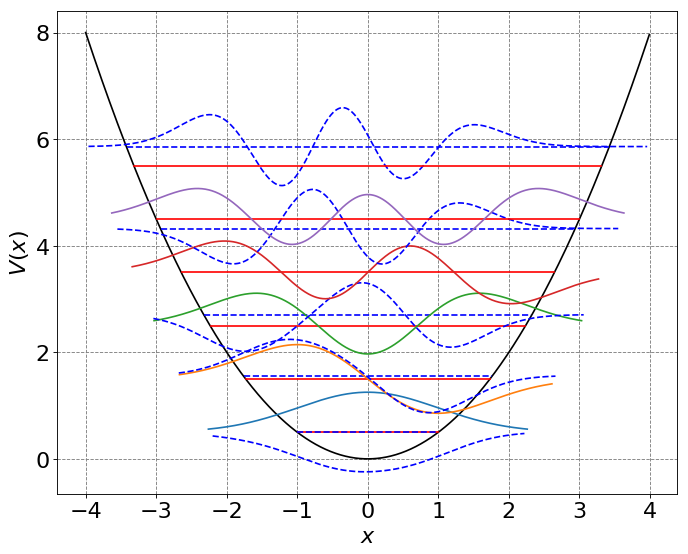

In [5]:
# let's plot the energy levels and wave functions
from scipy.special import hermite
from scipy.special import factorial
# start by defining N function for analytic solution to HO wavefunctions
def Nn(n,alpha):
    return 1/np.sqrt(2**n*factorial(n))*(alpha/np.pi)**0.25

# initialize a figure
ax = define_figure(xlabel="$x$",ylabel="$V(x)$")
hbar = 1.0
k = 1.0
m = 1.0
omega = np.sqrt(k/m)
alpha = np.sqrt(k*m)/hbar
x = np.arange(-4,4,0.01)
x2 = np.power(x,2)
U = 0.5 * (omega)**2 * x**2
ax.plot(x, U, 'k')
for n in range(8):
    # compute and plot energy levels
    evals = hbar*omega*(n+0.5)
    mask = np.where(evals > U)  
    ax.plot(x[mask], evals * np.ones(np.shape(x))[mask], 'r-', label="analytic")
    # plot variational energy levels
    mask = np.where(E5[n] > U)  
    ax.plot(x[mask], E5[n] * np.ones(np.shape(x))[mask], 'b--',label="variational")
    # compute and plot analytic wavefunctions
    psi = (-1)**n*Nn(n,alpha)*hermite(n)(np.sqrt(alpha)*x)*np.exp(-alpha*x2/2.0)
    Y = psi+evals  # shift wavefunction up in Y to be at energy level
    label = "n="+str(n)
    mask = np.where(Y > U-2.0)
    ax.plot(x[mask], Y[mask].real)
    # plot variational wavefunctions
    Y = psi5[:,n]+E5[n]  # shift wavefunction up in Y to be at energy level
    label = "n="+str(n)
    mask = np.where(Y > U-2.0)
    ax.plot(x[mask], Y[mask].real,'b--')
#plt.legend(fontsize=18)

In [ ]:
# run gaussian expansions
psi10, E = basis_ho(5)
psi12, E = basis_ho(6)
psi14, E = basis_ho(7)
psi16, E = basis_ho(8)
psi18, E = basis_ho(9)
psi20, E = basis_ho(10)
psi40, E = basis_ho(20)
psi = (-1)**9*Nn(9,alpha)*hermite(9)(np.sqrt(alpha)*x)*np.exp(-alpha*x2/2.0)
# initialize a figure
ax = define_figure(xlabel="x",ylabel="psi(x)")
# plot analytic result
ax.plot(x,psi,label="n=9 Analytic Result",lw=6,color='k')
# plot basis function expansion
ax.plot(x,psi10[:,9],label="n=9 11 gaussians",lw=3)
ax.plot(x,-psi12[:,9],label="n=9 13 gaussians",lw=3)
ax.plot(x,psi14[:,9],label="n=9 15 gaussians",lw=3)
ax.plot(x,psi16[:,9],label="n=9 17 gaussians",lw=3)
ax.plot(x,psi20[:,9],label="n=9 21 gaussians",lw=3)
ax.plot(x,-psi40[:,9],label="n=9 41 gaussians",lw=3)
# make legend
ax.legend(fontsize=20,markerscale=5.0)

In [ ]:
# initialize a figure
ax = define_figure(xlabel="x",ylabel="probability density")
#plt.ylim((0.0,np.amax(quantumB(x,3000))*1.25))
# plot analytic result
ax.plot(x,psi**2,label="n=9 Analytic Result",lw=6,color='k')
# plot basis function expansion
ax.plot(x,psi10[:,9]**2,label="n=9 10 gaussians",lw=3)
ax.plot(x,psi12[:,9]**2,label="n=9 12 gaussians",lw=3)
ax.plot(x,psi14[:,9]**2,label="n=9 14 gaussians",lw=3)
ax.plot(x,psi16[:,9]**2,label="n=9 16 gaussians",lw=3)
ax.plot(x,psi20[:,9]**2,label="n=9 20 gaussians",lw=3)
ax.plot(x,psi40[:,9]**2,label="n=9 40 gaussians",lw=3)
# make legend
ax.legend(fontsize=20,markerscale=5.0)

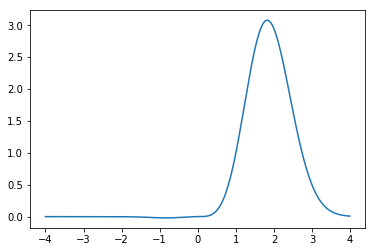

In [8]:
plt.plot(x,x**3*np.exp(-(x-1)**2))